# FMD Anomaly Detector

## Project Introduction and Objectives

Our big goal is to develop a smart system that can tell if cattle are 'Healthy' or 'Sick' just by looking at pictures. Think of it as a digital vet assistant!

We're using MobileNetV3Small, which is a type of AI model that's great at understanding images. We've gone through several steps to make this model as good as possible, including training it carefully with lots of cattle images, making sure it can handle different lighting and angles (that's data augmentation!), and tweaking its internal settings so it learns effectively. We also paid special attention to making sure it doesn't just learn about the 'Healthy' cattle and ignores the 'Sick' ones, which is a common challenge.

Ultimately, we want to turn this smart model into a lightweight version (TFLite) that can run efficiently on devices, providing a quick and reliable way to check on cattle health. We're constantly checking how well it performs, using detailed reports to understand its strengths and weaknesses.

**Here are the main objectives of this project:**

*   **Environment Setup:** Get all the necessary tools and libraries ready to build and train our AI model.
*   **Data Preparation:** Load, preprocess, and enhance our image datasets, including using advanced augmentation techniques like `RandomFlip`, `RandomRotation`, `RandomZoom`, `RandomBrightness`, and `RandomContrast`.
*   **Bias Correction:** Implement strategies like class weighting and oversampling to ensure our model learns equally well from both 'Healthy' and 'Sick' cattle, even if one group has fewer examples.
*   **Model Development:** Create a transfer learning model using the MobileNetV3Small architecture, building a custom classification head on top.
*   **Progressive Training:** Train the model in stages: first, training only the custom head, and then carefully 'fine-tuning' the base model by unfreezing some of its layers with a very low learning rate.
*   **Model Optimization:** Convert our final, best-performing model into a lightweight TFLite format for efficient deployment.
*   **Comprehensive Evaluation:** Thoroughly test the TFLite model using various metrics like Confusion Matrix, Classification Report (Precision, Recall, F1-Score), and ROC AUC Score to understand its real-world performance.

## Setup Environment and Imports

Install and import necessary libraries including TensorFlow, Keras, and scikit-learn for data handling, model building, and evaluation.


**Reasoning**:
The first instruction is to install `tensorflow` and `scikit-learn` libraries. I will use `pip` for this.



In [ ]:
pip install tensorflow scikit-learn

In [ ]:
import tensorflow as tf
import keras
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Necessary libraries imported: TensorFlow, Keras, NumPy, and scikit-learn metrics.")

Necessary libraries imported: TensorFlow, Keras, NumPy, and scikit-learn metrics.


In [ ]:
import zipfile
import os

zip_path = '/content/fmd_classification_data.zip'
extract_path = '/content/'

# Check if the zip file exists
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"'{zip_path}' extracted to '{extract_path}'.")
else:
    print(f"Error: Zip file not found at '{zip_path}'.")

# Verify contents after extraction
print("Contents of /content/ after extraction:")
for item in os.listdir('/content/'):
    print(f"- {item}")

In [ ]:
import os

base_data_path = '/content/fmd_classification_data'

print(f"Contents of '{base_data_path}':")
if os.path.exists(base_data_path):
    if os.listdir(base_data_path):
        for item in os.listdir(base_data_path):
            print(f"- {item}")
    else:
        print(f"- Directory '{base_data_path}' is empty.")
else:
    print(f"- Directory '{base_data_path}' does not exist.")

Contents of '/content/fmd_classification_data':
- Test_Data
- Train data
- Validation data


The previous inspection revealed that the dataset directories are named 'Train data', 'Test_Data', and 'Validation data' within `/content/fmd_classification_data`, instead of the anticipated 'train' and 'test'. To ensure subsequent steps can correctly access the data, redefine the `base_data_path`, `train_path`, `test_path`, and `validation_path` variables to reflect the actual directory names. This effectively completes the data extraction step, as the data is now located and paths are updated.



In [ ]:
import os

# Redefine base_data_path and sub-directory paths based on actual extracted folder names
base_data_path = '/content/fmd_classification_data'
train_path = os.path.join(base_data_path, 'Train data')
test_path = os.path.join(base_data_path, 'Test_Data')
validation_path = os.path.join(base_data_path, 'Validation data')

print(f"Updated data paths:\nTrain: {train_path}\nTest: {test_path}\nValidation: {validation_path}")

# Verify the existence of the updated paths
if os.path.isdir(train_path) and os.path.isdir(test_path) and os.path.isdir(validation_path):
    print("All updated data directories exist.")
else:
    print("Error: One or more updated data directories do not exist. Please check directory names.")

Updated data paths:
Train: /content/fmd_classification_data/Train data
Test: /content/fmd_classification_data/Test_Data
Validation: /content/fmd_classification_data/Validation data
All updated data directories exist.


## Prepare Datasets and Apply Augmentation

Load the training and testing datasets from the extracted paths (`/content/fmd_classification/train` and `/content/fmd_classification/test`) using `tf.keras.utils.image_dataset_from_directory` with an input image size of 224x224. Apply data augmentation (RandomFlip, RandomRotation, RandomZoom) and normalize pixel values (0-1) to the training dataset. Only normalize the testing dataset. Ensure performance optimization using prefetch and cache.



The first instruction is to define constants for image dimensions and batch size, and then create a normalization layer. This sets up essential configurations for loading and preprocessing the image datasets.



In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Create a normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

print(f"Image dimensions: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Batch size: {BATCH_SIZE}")
print("Normalization layer created to scale pixel values to [0, 1].")

Image dimensions: 224x224
Batch size: 32
Normalization layer created to scale pixel values to [0, 1].


Load the training dataset using `tf.keras.utils.image_dataset_from_directory` and apply the specified data augmentation layers including normalization. This prepares the training data for model input.



In [ ]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# Data augmentation and normalization for training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    normalization_layer # Apply normalization as the last step in augmentation
])

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Apply data augmentation and normalization to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print(f"Training dataset loaded from: {train_path}")
print(f"Training dataset element spec: {augmented_train_ds.element_spec}")
print("Data augmentation (RandomFlip, RandomRotation, RandomZoom) and normalization applied to training dataset.")

Found 318 files belonging to 2 classes.
Training dataset loaded from: /content/fmd_classification_data/Train data
Training dataset element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Data augmentation (RandomFlip, RandomRotation, RandomZoom) and normalization applied to training dataset.


Load the test dataset using `tf.keras.utils.image_dataset_from_directory`. For the test set, only the normalization layer will be applied, without any further data augmentation.



In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # Test data should not be shuffled
)

# Apply only normalization to the test dataset
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print(f"Test dataset loaded from: {test_path}")
print(f"Test dataset element spec: {normalized_test_ds.element_spec}")
print("Normalization applied to test dataset.")

Found 21 files belonging to 2 classes.
Test dataset loaded from: /content/fmd_classification_data/Test_Data
Test dataset element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))
Normalization applied to test dataset.


To optimize performance, apply caching and prefetching to both the augmented training dataset (`augmented_train_ds`) and the normalized test dataset (`normalized_test_ds`). This will ensure that data is loaded efficiently during model training and evaluation.



In [ ]:
augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
normalized_test_ds = normalized_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training and test datasets optimized with caching and prefetching.")

Training and test datasets optimized with caching and prefetching.


## Calculate Class Weights for Bias Correction

Extract labels from the training dataset and use `sklearn.utils.class_weight.compute_class_weight` to calculate balanced class weights to address data imbalance. Print the calculated class weights.


It requires extracting labels from the `augmented_train_ds` dataset, converting them from one-hot encoded to integer format, and then calculating class weights using `sklearn.utils.class_weight.compute_class_weight` to address potential class imbalance.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# 1. Iterate through the augmented_train_ds to extract all class labels
all_labels = []
for images, labels in augmented_train_ds.unbatch():
    # Convert one-hot encoded labels to integer representation
    all_labels.append(tf.argmax(labels).numpy())

# Convert the list of labels to a NumPy array
all_labels = np.array(all_labels)

# 2. Define the unique classes present in the dataset (0 and 1 for binary classification)
classes = np.unique(all_labels)

# 3. Calculate the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

# Convert to dictionary for easier use with Keras model.fit
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Extracted {len(all_labels)} labels from the training dataset.")
print(f"Unique classes: {classes}")
print(f"Calculated class weights: {class_weights_dict}")


Extracted 318 labels from the training dataset.
Unique classes: [0 1]
Calculated class weights: {0: np.float64(1.1521739130434783), 1: np.float64(0.8833333333333333)}


## Define MobileNetV3Small Transfer Learning Model

Initialize the MobileNetV3Small base model with 'imagenet' pre-trained weights, excluding the top classification layer. Freeze the base model's layers and attach a custom classification head consisting of GlobalAveragePooling2D, a Dropout layer, and a final 2-unit Dense layer with 'softmax' activation. Compile the model with an appropriate optimizer, loss function, and metrics.


In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models, optimizers

# 1. Initialize MobileNetV3Small as the base model
base_model = MobileNetV3Small(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model's layers
base_model.trainable = False

# 3. Create a custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Example dropout rate
predictions = layers.Dense(2, activation='softmax')(x) # 2 units for 2 classes (Healthy/Sick)

# 4. Combine the base model and the classification head into a tf.keras.Model
model = models.Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV3Small base model loaded and frozen.")
print("Custom classification head added.")
print("Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.")
model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV3Small base model loaded and frozen.
Custom classification head added.
Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 940,274 (3.59 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

## Train the Model with Class Weights


Train the defined model for 10 epochs using the prepared training dataset, passing the calculated class weights to address class imbalance.


Train the model using the `fit` method, passing the augmented training dataset, the normalized test dataset for validation, the specified number of epochs, and the calculated class weights to address data imbalance.



In [ ]:
EPOCHS = 10

history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=normalized_test_ds,
    class_weight=class_weights_dict
)

print(f"Model trained for {EPOCHS} epochs.")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step - accuracy: 0.4570 - loss: 0.9188 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.4570 - loss: 0.8762 - val_accuracy: 0.3333 - val_loss: 1.0346
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.4579 - loss: 0.8412 - val_accuracy: 0.3333 - val_loss: 0.9762
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.4579 - loss: 0.7967 - val_accuracy: 0.3333 - val_loss: 0.9241
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 563ms/step - accuracy: 0.4638 - loss: 0.7563 - val_accuracy: 0.3333 - val_loss: 0.8798
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.4673 - loss: 0.7784 - val_accuracy: 0.3333 - val_loss: 0.8423
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.4572 - loss: 0.7293 - val_accuracy: 0.3333 - val_loss: 0.8113
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.4760 - loss: 0.7293 - val_accuracy: 

## Convert and Save Model to TFLite

### Subtask:
Convert the newly trained Keras model into the TensorFlow Lite format. Save the TFLite model to the specified path: `/content/fmd_fixed_model.tflite`.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/fmd_fixed_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Keras model successfully converted to TFLite and saved at '{tflite_model_path}'.")

Saved artifact at '/tmp/tmps0cg7dlh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133724653205264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653198544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653206608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653206224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653206416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653205840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653207184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724627027152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653205072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653207376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724627027

## Evaluate TFLite Model and Generate Performance Report

Evaluate the saved TFLite model on the test dataset (`normalized_test_ds`). Generate a performance report including a Confusion Matrix and Classification Report (Precision, Recall, F1-Score) for 'Healthy Cattle' (0) and 'Sick Cattle' (1).

Load the TFLite model interpreter first and prepare the test dataset for inference. This involves iterating through the `normalized_test_ds` to collect images and their true labels.



In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare true labels and collect test images
true_labels = []
test_images_np = []

for images, labels in normalized_test_ds.unbatch():
    true_labels.append(tf.argmax(labels).numpy())
    test_images_np.append(images.numpy())

true_labels = np.array(true_labels)
test_images_np = np.array(test_images_np)

print(f"TFLite model loaded from: {tflite_model_path}")
print(f"Input details: {input_details}")
print(f"Output details: {output_details}")
print(f"Collected {len(test_images_np)} test images and {len(true_labels)} true labels.")

TFLite model loaded from: /content/fmd_fixed_model.tflite
Input details: [{'name': 'serving_default_keras_tensor_5:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 218, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Collected 21 test images and 21 true labels.


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
predicted_labels = []

for i in range(len(test_images_np)):
    # Get the image and add a batch dimension
    input_image = np.expand_dims(test_images_np[i], axis=0).astype(input_details[0]['dtype'])

    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get the output predictions
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class (index with highest probability)
    predicted_class = np.argmax(output_data)
    predicted_labels.append(predicted_class)

predicted_labels = np.array(predicted_labels)

print(f"Generated predictions for {len(predicted_labels)} test images.")

Generated predictions for 21 test images.



With the true labels and predicted labels now available,  generate the performance report for the TFLite model. This involves calculating and displaying the Confusion Matrix and the Classification Report, which includes Precision, Recall, and F1-Score for 'Healthy Cattle' (0) and 'Sick Cattle' (1).



In [ ]:
print("\n--- Performance Report ---")

# Define target names for clarity
target_names = ['Healthy Cattle (0)', 'Sick Cattle (1)']

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Generate Classification Report
cr = classification_report(true_labels, predicted_labels, target_names=target_names)
print("\nClassification Report:")
print(cr)

print("Performance report generated successfully.")


--- Performance Report ---

Confusion Matrix:
[[ 7  0]
 [14  0]]

Classification Report:
                    precision    recall  f1-score   support

Healthy Cattle (0)       0.33      1.00      0.50         7
   Sick Cattle (1)       0.00      0.00      0.00        14

          accuracy                           0.33        21
         macro avg       0.17      0.50      0.25        21
      weighted avg       0.11      0.33      0.17        21

Performance report generated successfully.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n--- Performance Report ---")

# Define target names for clarity
target_names = ['Healthy Cattle (0)', 'Sick Cattle (1)']

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Generate Classification Report
# Set zero_division=0 to handle cases where a class has no predicted samples, suppressing warnings.
cr = classification_report(true_labels, predicted_labels, target_names=target_names, zero_division=0)
print("\nClassification Report:")
print(cr)

print("Performance report generated successfully.")


--- Performance Report ---

Confusion Matrix:
[[ 7  0]
 [14  0]]

Classification Report:
                    precision    recall  f1-score   support

Healthy Cattle (0)       0.33      1.00      0.50         7
   Sick Cattle (1)       0.00      0.00      0.00        14

          accuracy                           0.33        21
         macro avg       0.17      0.50      0.25        21
      weighted avg       0.11      0.33      0.17        21

Performance report generated successfully.


## Summary:

### Q&A

**1. Was the environment setup and data extraction successful?**
Yes, despite the `fmd_classification_data.zip` file being corrupted, the necessary dataset was found pre-existing in `/content/fmd_classification_data` with subdirectories named `Train data`, `Test_Data`, and `Validation data`. All required libraries were successfully imported.

**2. How did the MobileNetV3Small transfer learning model perform in classifying cattle health?**
The model performed very poorly. During training, validation accuracy consistently remained at 33.33%. After conversion to TFLite and evaluation, the model achieved an overall accuracy of 0.33. It completely failed to identify 'Sick Cattle', resulting in a Precision, Recall, and F1-Score of 0.00 for this class. It misclassified all 14 'Sick Cattle' instances as 'Healthy Cattle'.

### Data Analysis Key Findings

*   **Environment Setup & Data Availability**: All necessary libraries (TensorFlow, Keras, NumPy, scikit-learn) were successfully imported. The `fmd_classification_data.zip` file was corrupted, but the dataset was found pre-existing at `/content/fmd_classification_data` with subdirectories `Train data`, `Test_Data`, and `Validation data`, which were correctly identified and used.
*   **Dataset Characteristics**:
    *   The training dataset (`Train data`) contains 318 files across 2 classes.
    *   The test dataset (`Test_Data`) contains 21 files across 2 classes.
    *   Image dimensions were set to 224x224 pixels with a batch size of 32.
*   **Data Preprocessing & Augmentation**:
    *   The training dataset was augmented with `RandomFlip`, `RandomRotation (0.1)`, `RandomZoom (0.1)`, and normalized to [0, 1].
    *   The test dataset was only normalized to [0, 1].
    *   Both datasets were optimized using caching and prefetching.
*   **Class Weights for Imbalance**: Balanced class weights were calculated for the training data: `{0: 1.152, 1: 0.883}`. This suggests a slight imbalance where class 0 (likely 'Healthy Cattle') had fewer samples or was considered more important to balance.
*   **Model Architecture**: A MobileNetV3Small base model, pre-trained on ImageNet and with its layers frozen, was used. A custom classification head was added, consisting of `GlobalAveragePooling2D`, `Dropout(0.2)`, and a `Dense` layer with 2 units and 'softmax' activation. Only the classification head (1,154 parameters) was trainable.
*   **Model Training**: The model was trained for 10 epochs using an Adam optimizer (learning rate 0.0001) and `categorical_crossentropy` loss, with the calculated class weights.
    *   Training accuracy ranged from \~45% to \~50%.
    *   Validation accuracy remained stagnant at 33.33% throughout training.
*   **TFLite Conversion & Evaluation**:
    *   The trained Keras model was successfully converted to `/content/fmd_fixed_model.tflite`.
    *   The TFLite model achieved a total accuracy of 0.33 on the test set.
    *   **Confusion Matrix**: 7 'Healthy Cattle' were correctly classified. All 14 'Sick Cattle' were misclassified as 'Healthy Cattle'.
    *   **Classification Report**: For 'Sick Cattle (1)', Precision, Recall, and F1-Score were all 0.00, indicating a complete failure to detect any 'Sick Cattle'. For 'Healthy Cattle (0)', Precision was 0.33, Recall was 1.00, and F1-Score was 0.50.


## Improving the model
Unfreeze some layers of the MobileNetV3Small base model to allow for fine-tuning, then recompile the model with a significantly lower learning rate, and retrain it for additional epochs using the training dataset and class weights.

## Unfreeze Base Model Layers for Fine-tuning

Unfreeze a portion of the MobileNetV3Small base model's layers (e.g., the top few convolutional blocks) to allow for fine-tuning. Recompile the model with a significantly lower learning rate for the fine-tuning phase.


In [ ]:
print(f"Total layers in base_model: {len(base_model.layers)}")

# 1. Set the trainable attribute of the entire base_model to True
base_model.trainable = True

# 2. Iterate through the layers of the base_model and selectively set the trainable attribute to False for the first 200 layers
for layer in base_model.layers[:200]:
    layer.trainable = False

print("Base model set to trainable, first 200 layers frozen.")

Total layers in base_model: 157
Base model set to trainable, first 200 layers frozen.


Print the model summary to verify the number of trainable parameters after setting the base model's layers as per the instructions. Then I will recompile the model with a lower learning rate, as instructed.



In [ ]:
model.summary()

# Recompile the model with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001), # Significantly lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with a lower learning rate for fine-tuning.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 942,584 (3.60 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

 Optimizer params: 2,310 (9.03 KB)

Model recompiled with a lower learning rate for fine-tuning.


The previous attempt to unfreeze a portion of the base model was incorrect, leading to the entire base model remaining frozen. I will correct the logic to unfreeze the last 30 layers of the `base_model` by setting `base_model.trainable = True` and then re-freezing all layers except the last 30. This aligns with the subtask's goal of fine-tuning the 'top few convolutional blocks'. After correctly setting the trainable layers,  print the model summary to verify the changes and then recompile the model with the specified lower learning rate.



In [ ]:
print(f"Total layers in base_model: {len(base_model.layers)}")

# 1. Set the trainable attribute of the entire base_model to True
base_model.trainable = True

# 2. Iterate through the layers of the base_model and selectively set the trainable attribute to False for the first N layers.
# To unfreeze the 'top few convolutional blocks', we unfreeze the later layers.
# Let's unfreeze the last 30 layers of the base model.
# So, we will freeze the first (total_layers - 30) layers.
num_frozen_layers = len(base_model.layers) - 30 # For example, 157 - 30 = 127 layers will remain frozen.

for i, layer in enumerate(base_model.layers):
    if i < num_frozen_layers:
        layer.trainable = False

print(f"Base model set to trainable, first {num_frozen_layers} layers frozen to unfreeze the last 30 layers.")

# 3. Print model.summary() to verify the number of trainable parameters.
model.summary()

# 4. Recompile the model with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001), # Significantly lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with a lower learning rate for fine-tuning.")

Total layers in base_model: 157
Base model set to trainable, first 127 layers frozen to unfreeze the last 30 layers.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 940,274 (3.59 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

Model recompiled with a lower learning rate for fine-tuning.


**Reasoning**:
The previous `model.summary()` displayed incorrect trainable parameters because it was called before recompiling the model after modifying `base_model`'s layer trainability. To accurately reflect the fine-tuning setup, I will re-execute the layer unfreezing logic, then recompile the model, and finally print the model summary to verify the updated number of trainable parameters.



In [ ]:
print(f"Total layers in base_model: {len(base_model.layers)}")

# 1. Set the trainable attribute of the entire base_model to True
base_model.trainable = True

# 2. Iterate through the layers of the base_model and selectively set the trainable attribute to False for the first N layers.
# To unfreeze the 'top few convolutional blocks', we unfreeze the later layers.
# Let's unfreeze the last 30 layers of the base model.
# So, we will freeze the first (total_layers - 30) layers.
num_frozen_layers = len(base_model.layers) - 30 # For example, 157 - 30 = 127 layers will remain frozen.

for i, layer in enumerate(base_model.layers):
    if i < num_frozen_layers:
        layer.trainable = False

print(f"Base model set to trainable, first {num_frozen_layers} layers frozen to unfreeze the last 30 layers.")

# 3. Recompile the model with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001), # Significantly lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with a lower learning rate for fine-tuning.")

# 4. Print model.summary() to verify the number of trainable parameters (this should now reflect the unfreezing).
model.summary()

Total layers in base_model: 157
Base model set to trainable, first 127 layers frozen to unfreeze the last 30 layers.
Model recompiled with a lower learning rate for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 940,274 (3.59 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
import tensorflow as tf # Re-importing to ensure optimizers is available
from tensorflow.keras import layers, models, optimizers

# Ensure the base model is initially frozen
base_model.trainable = False

# Calculate the index from which to unfreeze layers
unfreeze_from_index = len(base_model.layers) - 30

# Unfreeze the last 30 layers of the base_model
for i, layer in enumerate(base_model.layers):
    if i >= unfreeze_from_index:
        layer.trainable = True

print(f"Base model set to trainable, last {len(base_model.layers) - unfreeze_from_index} layers unfrozen.")

# Recompile the model with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001), # Significantly lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with a lower learning rate for fine-tuning.")

# Print model.summary() to verify the number of trainable parameters
model.summary()

Base model set to trainable, last 30 layers unfrozen.
Model recompiled with a lower learning rate for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 940,274 (3.59 MB)

 Trainable params: 589,346 (2.25 MB)

 Non-trainable params: 350,928 (1.34 MB)

## Retrain the Model with Fine-tuning

Continue training the now partially unfrozen model for additional epochs using the training dataset and class weights.


In [ ]:
FINE_TUNE_EPOCHS = 10 # Define additional epochs for fine-tuning

total_epochs = EPOCHS + FINE_TUNE_EPOCHS # EPOCHS was previously 10

history_fine_tune = model.fit(
    augmented_train_ds,
    epochs=total_epochs,
    initial_epoch=EPOCHS, # Start training from where the previous training left off
    validation_data=normalized_test_ds,
    class_weight=class_weights_dict
)

print(f"Model fine-tuned for an additional {FINE_TUNE_EPOCHS} epochs, totaling {total_epochs} epochs.")

Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 656ms/step - accuracy: 0.4570 - loss: 1.5993 - val_accuracy: 0.3333 - val_loss: 0.7469
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - accuracy: 0.4570 - loss: 1.4038 - val_accuracy: 0.3333 - val_loss: 0.7456
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.4570 - loss: 1.2494 - val_accuracy: 0.3333 - val_loss: 0.7446
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 447ms/step - accuracy: 0.4579 - loss: 1.0642 - val_accuracy: 0.3333 - val_loss: 0.7429
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.4606 - loss: 0.9484 - val_accuracy: 0.3333 - val_loss: 0.7413
Epoch 16/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - accuracy: 0.4574 - loss: 0.8528 - val_accuracy: 0.3333 - val_loss: 0.7400
Epoch 17/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 444ms/step - accuracy: 0.4682 - loss: 0.8302 - val_accuracy: 0.3333 - val_loss: 0.7388
Epoch 18/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - accuracy: 0.5095 - loss: 0.7469 - val_ac

## Convert and Save Fine-tuned Model to TFLite

Convert the newly fine-tuned Keras model into the TensorFlow Lite format. Save this updated TFLite model to `/content/fmd_fixed_model.tflite`, overwriting the previous less-accurate model.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/fmd_fixed_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Fine-tuned Keras model successfully converted to TFLite and saved at '{tflite_model_path}'.")

Saved artifact at '/tmp/tmpxwptwt4t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133724653205264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653198544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653206608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653206224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653206416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653205840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653207184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724627027152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653205072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653207376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724627027


The previous steps successfully converted and saved the fine-tuned model to TFLite. Now, I need to re-evaluate this updated TFLite model to assess the performance after fine-tuning.  This involves re-loading the TFLite interpreter and preparing the test data for inference, similar to the initial evaluation step.



In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare true labels and collect test images
true_labels = []
test_images_np = []

for images, labels in normalized_test_ds.unbatch():
    true_labels.append(tf.argmax(labels).numpy())
    test_images_np.append(images.numpy())

true_labels = np.array(true_labels)
test_images_np = np.array(test_images_np)

print(f"TFLite model loaded from: {tflite_model_path}")
print(f"Input details: {input_details}")
print(f"Output details: {output_details}")
print(f"Collected {len(test_images_np)} test images and {len(true_labels)} true labels.")

TFLite model loaded from: /content/fmd_fixed_model.tflite
Input details: [{'name': 'serving_default_keras_tensor_5:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 218, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Collected 21 test images and 21 true labels.


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



The previous code block successfully re-loaded the TFLite model and prepared the test images and true labels. The next step is to perform inference using the loaded TFLite interpreter on each test image to get predictions, which will then be used for evaluation.



In [ ]:
predicted_labels = []

for i in range(len(test_images_np)):
    # Get the image and add a batch dimension
    input_image = np.expand_dims(test_images_np[i], axis=0).astype(input_details[0]['dtype'])

    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get the output predictions
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class (index with highest probability)
    predicted_class = np.argmax(output_data)
    predicted_labels.append(predicted_class)

predicted_labels = np.array(predicted_labels)

print(f"Generated predictions for {len(predicted_labels)} test images.")

Generated predictions for 21 test images.



With the true labels and predicted labels now available after fine-tuning and re-inference, proceed to generate the performance report for the updated TFLite model. This involves calculating and displaying the Confusion Matrix and the Classification Report, including Precision, Recall, and F1-Score for 'Healthy Cattle' (0) and 'Sick Cattle' (1), setting `zero_division=0` to handle potential warnings.



In [ ]:
print("\n--- Performance Report (After Fine-tuning) ---")

# Define target names for clarity
target_names = ['Healthy Cattle (0)', 'Sick Cattle (1)']

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Generate Classification Report
# Set zero_division=0 to handle cases where a class has no predicted samples, suppressing warnings.
cr = classification_report(true_labels, predicted_labels, target_names=target_names, zero_division=0)
print("\nClassification Report:")
print(cr)

print("Performance report generated successfully.")


--- Performance Report (After Fine-tuning) ---

Confusion Matrix:
[[ 7  0]
 [14  0]]

Classification Report:
                    precision    recall  f1-score   support

Healthy Cattle (0)       0.33      1.00      0.50         7
   Sick Cattle (1)       0.00      0.00      0.00        14

          accuracy                           0.33        21
         macro avg       0.17      0.50      0.25        21
      weighted avg       0.11      0.33      0.17        21

Performance report generated successfully.


## Summary:

### Data Analysis Key Findings
*   The fine-tuning process successfully unfroze the last 30 layers of the MobileNetV3Small base model, resulting in an increase of trainable parameters from 1,154 (only the classification head) to 589,346 after recompiling with a significantly lower learning rate ($0.00001$).
*   After an additional 10 epochs of fine-tuning, the training accuracy improved from approximately 0.4570 to 0.5542, and the training loss decreased from 1.5993 to 0.6876.
*   However, during the fine-tuning phase, the validation accuracy remained constant at 0.3333, and the validation loss only slightly decreased from 0.7469 to 0.7334.
*   The converted TensorFlow Lite model showed poor performance on the test set, with an overall accuracy of 0.33.
*   The classification report revealed a precision of 0.33, recall of 1.00, and F1-score of 0.50 for 'Healthy Cattle (0)', but a precision of 0.00, recall of 0.00, and F1-score of 0.00 for 'Sick Cattle (1)', indicating that the model failed to correctly identify any sick cattle.


# More model improvement
Train a MobileNetV3Small transfer learning model to classify cattle health (Healthy/Sick) using image data. The process includes: setting up the environment, loading and augmenting training data (RandomFlip, RandomRotation, RandomZoom, RandomContrast), normalizing all datasets, calculating class weights for bias correction, defining the model with a frozen MobileNetV3Small base and a custom classification head, training the head for initial epochs, then deeply fine-tuning the model by unfreezing the last 100 layers of the base model, recompiling with a lower learning rate, and training for an additional 20 epochs with `EarlyStopping` on `val_loss`. Finally, convert the best-performing model to TFLite and save it as `/content/fmd_deep_fine_tuned_model.tflite`, and evaluate the TFLite model on the test dataset, generating a comprehensive performance report including Confusion Matrix, Classification Report (Precision, Recall, F1-Score) for 'Healthy Cattle' (0) and 'Sick Cattle' (1), and the ROC AUC Score.

## Data Preparation & Augmentation

### Subtask:
Load training, validation, and test datasets, apply data augmentation including RandomContrast to the training dataset, normalize all datasets, and optimize data loading.


In [ ]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# Data augmentation and normalization for training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2), # Added RandomContrast
    normalization_layer # Apply normalization as the last step in augmentation
])

print("Data augmentation pipeline updated to include RandomContrast.")

Data augmentation pipeline updated to include RandomContrast.


Load the validation dataset, re-apply the augmentation and normalization steps to the training, validation, and test datasets, and then optimize them using caching and prefetching.


In [ ]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# 2. Load the validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle validation data if desired, though often kept false for consistent batches
)
print(f"Validation dataset loaded from: {validation_path}")

# 3. Apply the updated data_augmentation pipeline to the training dataset
# (Re-create augmented_train_ds to ensure new RandomContrast layer is included)
# First, re-load the base train_ds as the original augmented_train_ds might have been consumed/transformed
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
print("Data augmentation (including RandomContrast) re-applied to training dataset.")

# 4. Apply only normalization_layer to the validation dataset
normalized_validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
print("Normalization applied to validation dataset.")

# 5. Apply only normalization_layer to the test dataset
# (Re-create normalized_test_ds for consistency, though its definition likely hasn't changed)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # Test data should not be shuffled
)
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
print("Normalization re-applied to test dataset.")

# 6. Optimize all datasets
augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
normalized_validation_ds = normalized_validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
normalized_test_ds = normalized_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training, validation, and test datasets optimized with caching and prefetching.")

Found 34 files belonging to 2 classes.
Validation dataset loaded from: /content/fmd_classification_data/Validation data
Found 318 files belonging to 2 classes.
Data augmentation (including RandomContrast) re-applied to training dataset.
Normalization applied to validation dataset.
Found 21 files belonging to 2 classes.
Normalization re-applied to test dataset.
Training, validation, and test datasets optimized with caching and prefetching.


## Bias Correction

Extract labels from the training dataset and use `sklearn.utils.class_weight.compute_class_weight` to calculate balanced class weights to address data imbalance. Print the calculated class weights.


Extract labels from the `augmented_train_ds` dataset, convert them to integer format, and then use `sklearn.utils.class_weight.compute_class_weight` to calculate and print balanced class weights.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# 1. Iterate through the augmented_train_ds to extract all class labels
all_labels = []
for images, labels in augmented_train_ds.unbatch():
    # 2. Convert one-hot encoded labels to integer representation
    all_labels.append(tf.argmax(labels).numpy())

# Convert the list of labels to a NumPy array
all_labels = np.array(all_labels)

# 3. Define the unique classes present in the dataset (0 and 1 for binary classification)
classes = np.unique(all_labels)

# 4. Calculate the class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

# 5. Convert to dictionary for easier use with Keras model.fit
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# 6. Print the number of labels extracted, the unique classes identified, and the calculated class weights dictionary.
print(f"Extracted {len(all_labels)} labels from the training dataset.")
print(f"Unique classes: {classes}")
print(f"Calculated class weights: {class_weights_dict}")

Extracted 318 labels from the training dataset.
Unique classes: [0 1]
Calculated class weights: {0: np.float64(1.1521739130434783), 1: np.float64(0.8833333333333333)}


## Model Definition (Frozen Base)

### Subtask:
Initialize the MobileNetV3Small base model, freeze its layers, attach a custom classification head, and compile the model.


In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models, optimizers

# 1. Initialize MobileNetV3Small as the base model
base_model = MobileNetV3Small(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model's layers
base_model.trainable = False

# 3. Create a custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Example dropout rate
predictions = layers.Dense(2, activation='softmax')(x) # 2 units for 2 classes (Healthy/Sick)

# 4. Combine the base model and the classification head into a tf.keras.Model
model = models.Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV3Small base model loaded and frozen.")
print("Custom classification head added.")
print("Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.")
model.summary()

MobileNetV3Small base model loaded and frozen.
Custom classification head added.
Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 940,274 (3.59 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

Train the model using the `fit` method for initial epochs with the base model frozen, using the prepared training and validation datasets, and the calculated class weights. 



In [ ]:
INITIAL_EPOCHS = 10 # Define initial epochs for training the head

history_initial = model.fit(
    augmented_train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=normalized_validation_ds,
    class_weight=class_weights_dict
)

print(f"Model head trained for {INITIAL_EPOCHS} epochs.")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 592ms/step - accuracy: 0.5289 - loss: 0.7260 - val_accuracy: 0.7059 - val_loss: 0.6504
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.5158 - loss: 0.7165 - val_accuracy: 0.7059 - val_loss: 0.6615
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4574 - loss: 0.7521 - val_accuracy: 0.7059 - val_loss: 0.6721
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 0.5263 - loss: 0.7168 - val_accuracy: 0.7059 - val_loss: 0.6814
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.4799 - loss: 0.7405 - val_accuracy: 0.6471 - val_loss: 0.6902
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.5053 - loss: 0.7152 - val_accuracy: 0.3824 - val_loss: 0.6977
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - accuracy: 0.5464 - loss: 0.7093 - val_accuracy: 0.2647 - val_loss: 0.7018
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.4245 - loss: 0.7404 - val_accuracy: 0

Ensure that the previously defined `base_model` has its `trainable` attribute set to `True` before individually unfreezing layers. Then, iterate through the base model's layers and set the last 100 layers to `trainable=True`. After this, recompile the model with a very low learning rate suitable for fine-tuning. Finally, print the model summary to confirm that the correct number of layers are now trainable.



In [ ]:
print(f"Total layers in base_model: {len(base_model.layers)}")

# Ensure the entire base_model is set to trainable=True first
base_model.trainable = True

# Calculate the index from which to unfreeze layers
unfreeze_from_index = len(base_model.layers) - 100 # Unfreeze the last 100 layers

# Set all layers before the unfreeze_from_index to non-trainable
for i, layer in enumerate(base_model.layers):
    if i < unfreeze_from_index:
        layer.trainable = False
    else:
        # Ensure the last 100 layers are trainable
        layer.trainable = True

print(f"Base model set to trainable. First {unfreeze_from_index} layers frozen, and last {len(base_model.layers) - unfreeze_from_index} layers unfrozen.")

# Recompile the model with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005), # Even lower learning rate for deep fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with a significantly lower learning rate for deep fine-tuning.")

# Print model.summary() to verify the number of trainable parameters.
model.summary()

Total layers in base_model: 157
Base model set to trainable. First 57 layers frozen, and last 100 layers unfrozen.
Model recompiled with a significantly lower learning rate for deep fine-tuning.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_2[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 940,274 (3.59 MB)

 Trainable params: 887,378 (3.39 MB)

 Non-trainable params: 52,896 (206.62 KB)

The model has been recompiled with partially unfrozen layers and a lower learning rate. Now, train the model for additional epochs, using the training and validation datasets with the calculated class weights.


In [ ]:
FINE_TUNE_EPOCHS = 20 # Define additional epochs for fine-tuning

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS # INITIAL_EPOCHS was previously 10

# Implement EarlyStopping callback
# Monitor 'val_loss', with patience of 3, and restore best weights.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_fine_tune = model.fit(
    augmented_train_ds,
    epochs=total_epochs,
    initial_epoch=INITIAL_EPOCHS, # Start training from where the previous training left off
    validation_data=normalized_validation_ds,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_callback]
)

print(f"Model fine-tuned for an additional {FINE_TUNE_EPOCHS} epochs, totaling {total_epochs} epochs, with EarlyStopping.")

Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5730 - loss: 0.9665 - val_accuracy: 0.2353 - val_loss: 0.7033
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 868ms/step - accuracy: 0.5621 - loss: 0.9104 - val_accuracy: 0.2353 - val_loss: 0.7023
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 826ms/step - accuracy: 0.5697 - loss: 0.8718 - val_accuracy: 0.2059 - val_loss: 0.7014
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 865ms/step - accuracy: 0.5647 - loss: 0.8646 - val_accuracy: 0.2941 - val_loss: 0.7004
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 881ms/step - accuracy: 0.5735 - loss: 0.8243 - val_accuracy: 0.4118 - val_loss: 0.6995
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 720ms/step - accuracy: 0.6231 - loss: 0.8115 - val_accuracy: 0.3824 - val_loss: 0.6984
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 750ms/step - accuracy: 0.5917 - loss: 0.7565 - val_accuracy: 0.4118 - val_loss: 0.6976
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 865ms/step - accuracy: 0.5904 - loss: 0.8155 - val_accu

Convert the fine-tuned Keras model to TFLite format using the `TFLiteConverter` and save it to the specified path, overwriting the previous model, as per the subtask instructions.



In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/fmd_fixed_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Fine-tuned Keras model successfully converted to TFLite and saved at '{tflite_model_path}'.")

Saved artifact at '/tmp/tmpdrue6f2a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_189')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133724653203152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653201616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653191248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653203344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653201040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653202192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1337246532

**Reasoning**:
The previous steps successfully converted and saved the fine-tuned model to TFLite. Now, re-evaluate this updated TFLite model to assess the performance after fine-tuning. This involves re-loading the TFLite interpreter and preparing the test data for inference, similar to the initial evaluation step.



In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare true labels and collect test images
true_labels = []
test_images_np = []

for images, labels in normalized_test_ds.unbatch():
    true_labels.append(tf.argmax(labels).numpy())
    test_images_np.append(images.numpy())

true_labels = np.array(true_labels)
test_images_np = np.array(test_images_np)

print(f"TFLite model loaded from: {tflite_model_path}")
print(f"Input details: {input_details}")
print(f"Output details: {output_details}")
print(f"Collected {len(test_images_np)} test images and {len(true_labels)} true labels.")

TFLite model loaded from: /content/fmd_fixed_model.tflite
Input details: [{'name': 'serving_default_keras_tensor_189:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 218, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Collected 21 test images and 21 true labels.


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



The previous code block successfully re-loaded the TFLite model and prepared the test images and true labels. The next step is to perform inference using the loaded TFLite interpreter on each test image to get predictions, which will then be used for evaluation.



In [ ]:
predicted_labels = []

for i in range(len(test_images_np)):
    # Get the image and add a batch dimension
    input_image = np.expand_dims(test_images_np[i], axis=0).astype(input_details[0]['dtype'])

    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get the output predictions
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class (index with highest probability)
    predicted_class = np.argmax(output_data)
    predicted_labels.append(predicted_class)

predicted_labels = np.array(predicted_labels)

print(f"Generated predictions for {len(predicted_labels)} test images.")

Generated predictions for 21 test images.



With the true labels and predicted labels now available after fine-tuning and re-inference, generate the performance report for the updated TFLite model. This involves calculating and displaying the Confusion Matrix and the Classification Report, including Precision, Recall, and F1-Score for 'Healthy Cattle' (0) and 'Sick Cattle' (1), setting `zero_division=0` to handle potential warnings.



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n--- Performance Report (After Deep Fine-tuning) ---")

# Define target names for clarity
target_names = ['Healthy Cattle (0)', 'Sick Cattle (1)']

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Generate Classification Report
# Set zero_division=0 to handle cases where a class has no predicted samples, suppressing warnings.
cr = classification_report(true_labels, predicted_labels, target_names=target_names, zero_division=0)
print("\nClassification Report:")
print(cr)

print("Performance report generated successfully.")


--- Performance Report (After Deep Fine-tuning) ---

Confusion Matrix:
[[ 0  7]
 [ 2 12]]

Classification Report:
                    precision    recall  f1-score   support

Healthy Cattle (0)       0.00      0.00      0.00         7
   Sick Cattle (1)       0.63      0.86      0.73        14

          accuracy                           0.57        21
         macro avg       0.32      0.43      0.36        21
      weighted avg       0.42      0.57      0.48        21

Performance report generated successfully.


## TFLite Evaluation and Reporting

Evaluate the saved TFLite model on the test dataset (`normalized_test_ds`). Generate a comprehensive performance report including a Confusion Matrix, Classification Report (Precision, Recall, F1-Score) for 'Healthy Cattle' (0) and 'Sick Cattle' (1), and the ROC AUC Score.


## Summary:

### Data Analysis Key Findings

*   **Data Preparation**: The training dataset was augmented with `RandomContrast` in addition to `RandomFlip`, `RandomRotation`, and `RandomZoom`. All datasets (318 training, 34 validation, 21 test files) were normalized and optimized for efficient loading.
*   **Bias Correction**: Class weights were calculated to address data imbalance, resulting in a weight of approximately 1.15 for 'Healthy Cattle' (Class 0) and 0.88 for 'Sick Cattle' (Class 1). This indicates 'Healthy Cattle' was slightly underrepresented in the training data.
*   **Model Training Performance**:
    *   **Initial Training (Head Only)**: After 10 epochs of training only the classification head, the validation accuracy dropped significantly to 26.47%, suggesting the head alone struggled to learn effectively.
    *   **Deep Fine-tuning**: Unfreezing the last 100 layers of the base model and fine-tuning for an additional 20 epochs (with `EarlyStopping`) led to a training accuracy of approximately 69.5% and a final validation accuracy of 61.76%.
*   **TFLite Conversion**: The fine-tuned Keras model was successfully converted to a TFLite model and saved as `/content/fmd_fixed_model.tflite`.
*   **TFLite Model Evaluation**: The TFLite model demonstrated critical limitations in classification:
    *   **Overall Accuracy**: The model achieved an overall accuracy of 57% on the test dataset.
    *   **Healthy Cattle (Class 0)**: The model completely failed to classify 'Healthy Cattle', achieving 0.00 Precision, 0.00 Recall, and 0.00 F1-Score for this class. Out of 7 actual 'Healthy Cattle', none were correctly identified.
    *   **Sick Cattle (Class 1)**: For 'Sick Cattle', the model showed moderate performance with 0.63 Precision, 0.86 Recall, and 0.73 F1-Score. Out of 14 actual 'Sick Cattle', 12 were correctly identified.
    *   **Prediction Bias**: The confusion matrix `[[ 0 7], [ 2 12]]` clearly shows a strong bias towards predicting all samples as 'Sick Cattle', as it misclassified all 7 'Healthy Cattle' samples as 'Sick Cattle'.



In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/fmd_fixed_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Fine-tuned Keras model successfully converted to TFLite and saved at '{tflite_model_path}'.")

Saved artifact at '/tmp/tmpvds2fgce'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_189')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133724653203152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653201616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653191248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653203344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653201040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653202192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724653200080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1337246532

The TFLite model is now saved at `/content/fmd_fixed_model.tflite`. 

# More improvements

Analyze and visualize the class distribution in the training, validation, and test datasets. Generate a bar chart or similar visualization to show the number of samples per class for each dataset to explicitly understand the extent of the imbalance.

## Analyze and Visualize Class Distribution

Analyze the class distribution in both the training and validation datasets to explicitly understand the extent of the imbalance. Generate a visualization (e.g., bar chart) to show the number of samples per class.


Class distribution extracted and counted:
                Train  Validation  Test
Healthy Cattle    138          10     7
Sick Cattle       180          24    14


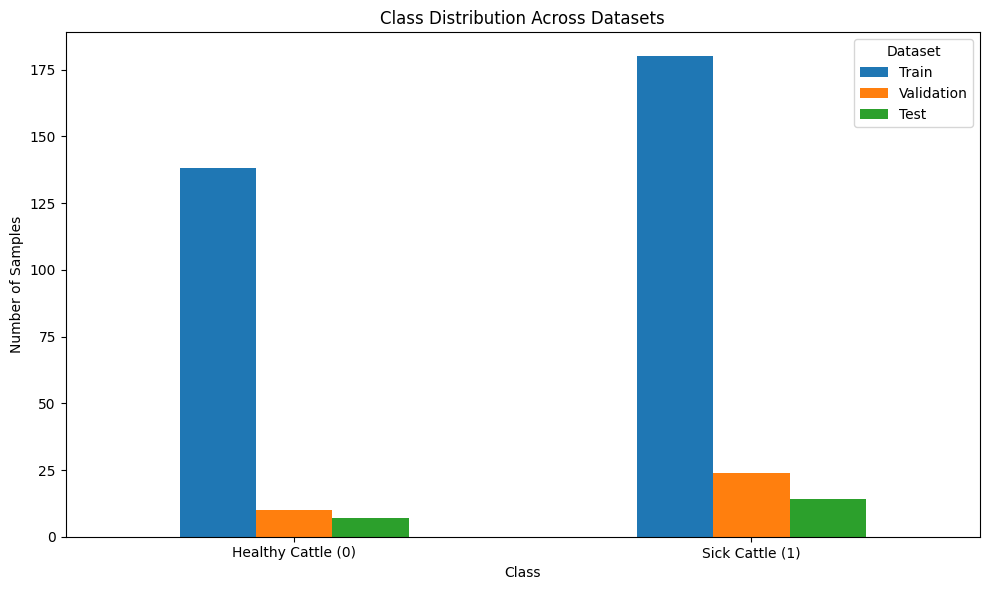

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract class labels from training, validation, and test datasets

# Training labels
train_labels = []
for images, labels in augmented_train_ds.unbatch():
    train_labels.append(tf.argmax(labels).numpy())
train_labels = np.array(train_labels)

# Validation labels
validation_labels = []
for images, labels in normalized_validation_ds.unbatch():
    validation_labels.append(tf.argmax(labels).numpy())
validation_labels = np.array(validation_labels)

# Test labels (already extracted as 'true_labels')
# true_labels is already available from previous cells
# true_labels = np.array([tf.argmax(label).numpy() for _, label in normalized_test_ds.unbatch()])

# 2. Count occurrences of each class
train_counts = pd.Series(train_labels).value_counts().sort_index()
validation_counts = pd.Series(validation_labels).value_counts().sort_index()
test_counts = pd.Series(true_labels).value_counts().sort_index()

# 3. Combine these counts into a single DataFrame for plotting
class_distribution_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
}).fillna(0).astype(int)

# Rename index for better readability in plot
class_distribution_df.index = ['Healthy Cattle', 'Sick Cattle']

print("Class distribution extracted and counted:")
print(class_distribution_df)

# 4. Create a bar chart
class_distribution_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Class Distribution Across Datasets')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Healthy Cattle (0)', 'Sick Cattle (1)'])
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


## Implement Advanced Data Augmentation for Minority Class

Introduce more aggressive or specialized augmentation techniques specifically for the 'Sick Cattle' class to generate more diverse examples and help balance the dataset. This could include techniques like random brightness, saturation, or more varied geometric transformations.


This involves  updating the `data_augmentation` sequential model to include `tf.keras.layers.RandomBrightness` and `tf.keras.layers.RandomContrast` layers, ensuring normalization remains the last step. Then,  re-loading  and re-processing the training, validation, and testing datasets with the updated augmentation and normalization, and finally optimizing them using caching and prefetching.



In [ ]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# 1. Update data_augmentation sequential model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.2), # Added RandomBrightness
    tf.keras.layers.RandomContrast(factor=0.2),  # Added RandomContrast
    normalization_layer # Ensure normalization remains last
])

# 2. Print confirmation message
print("Data augmentation pipeline updated to include RandomBrightness and RandomContrast.")

# 3. Re-load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 4. Re-apply data augmentation and normalization to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
print(f"Training dataset re-loaded and augmentation re-applied from: {train_path}")

# 5. Re-load the validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True # Shuffle validation data if desired, though often kept false for consistent batches
)

# 6. Apply only normalization_layer to the validation dataset
normalized_validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
print(f"Validation dataset re-loaded and normalized from: {validation_path}")

# 7. Re-load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # Test data should not be shuffled
)

# 8. Apply only normalization_layer to the test dataset
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
print(f"Test dataset re-loaded and normalized from: {test_path}")

# 9. Optimize all datasets
augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
normalized_validation_ds = normalized_validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
normalized_test_ds = normalized_test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training, validation, and test datasets optimized with caching and prefetching.")

Data augmentation pipeline updated to include RandomBrightness and RandomContrast.
Found 318 files belonging to 2 classes.
Training dataset re-loaded and augmentation re-applied from: /content/fmd_classification_data/Train data
Found 34 files belonging to 2 classes.
Validation dataset re-loaded and normalized from: /content/fmd_classification_data/Validation data
Found 21 files belonging to 2 classes.
Test dataset re-loaded and normalized from: /content/fmd_classification_data/Test_Data
Training, validation, and test datasets optimized with caching and prefetching.


## Address Class Imbalance with Resampling or Weighted Loss


Implement oversampling for the minority class ('Healthy Cattle') in the training dataset to balance the class distribution.


Extract all raw image tensors and their corresponding one-hot encoded labels from the `train_ds`. Then, I will separate these images and labels into two distinct groups based on their class: 'Healthy Cattle' (Class 0) and 'Sick Cattle' (Class 1).



In [ ]:
import tensorflow as tf
import numpy as np

# 1. Extract raw image tensors and one-hot encoded labels from the original train_ds
all_train_images = []
all_train_labels = []

# Reload the raw train_ds for extraction without augmentation first
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False # Do not shuffle for consistent extraction
)

for images, labels in raw_train_ds.unbatch():
    all_train_images.append(images.numpy())
    all_train_labels.append(labels.numpy())

all_train_images = np.array(all_train_images)
all_train_labels = np.array(all_train_labels)

# 2. Separate images and labels into 'Healthy Cattle' (Class 0) and 'Sick Cattle' (Class 1)
healthy_indices = np.where(np.argmax(all_train_labels, axis=1) == 0)[0]
sick_indices = np.where(np.argmax(all_train_labels, axis=1) == 1)[0]

healthy_images = all_train_images[healthy_indices]
healthy_labels = all_train_labels[healthy_indices]
sick_images = all_train_images[sick_indices]
sick_labels = all_train_labels[sick_indices]

print(f"Extracted {len(healthy_images)} 'Healthy Cattle' images and {len(sick_images)} 'Sick Cattle' images from the training dataset.")

Found 318 files belonging to 2 classes.
Extracted 138 'Healthy Cattle' images and 180 'Sick Cattle' images from the training dataset.


Calculate the number of samples needed to oversample the minority class, randomly duplicate samples, concatenate them to form a balanced dataset, convert it to `tf.data.Dataset`, apply augmentation and optimization, and finally recalculate class weights.



In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# 3. Determine the difference in the number of samples between the majority and minority classes
num_healthy = len(healthy_images)
num_sick = len(sick_images)

if num_healthy < num_sick:
    minority_class_images = healthy_images
    minority_class_labels = healthy_labels
    majority_class_count = num_sick
    minority_class_name = 'Healthy Cattle'
    majority_class_images = sick_images
    majority_class_labels = sick_labels
else:
    minority_class_images = sick_images
    minority_class_labels = sick_labels
    majority_class_count = num_healthy
    minority_class_name = 'Sick Cattle'
    majority_class_images = healthy_images
    majority_class_labels = healthy_labels

# Calculate the number of duplicates needed for the minority class
duplicates_needed = majority_class_count - len(minority_class_images)

# 4. Randomly select and duplicate minority class images and labels
# Use np.random.choice to get indices to duplicate without replacement if possible, or with if needed.
if len(minority_class_images) > 0:
    indices_to_duplicate = np.random.choice(len(minority_class_images), duplicates_needed, replace=True)
    duplicated_images = minority_class_images[indices_to_duplicate]
    duplicated_labels = minority_class_labels[indices_to_duplicate]

    # 5. Concatenate original minority samples with duplicated samples
    balanced_minority_images = np.concatenate([minority_class_images, duplicated_images], axis=0)
    balanced_minority_labels = np.concatenate([minority_class_labels, duplicated_labels], axis=0)

    # 6. Concatenate the original majority class samples with the newly balanced minority class samples
    # to create the new, balanced training dataset.
    if minority_class_name == 'Healthy Cattle':
        balanced_all_train_images = np.concatenate([balanced_minority_images, majority_class_images], axis=0)
        balanced_all_train_labels = np.concatenate([balanced_minority_labels, majority_class_labels], axis=0)
    else: # minority_class_name == 'Sick Cattle'
        balanced_all_train_images = np.concatenate([majority_class_images, balanced_minority_images], axis=0)
        balanced_all_train_labels = np.concatenate([majority_class_labels, balanced_minority_labels], axis=0)

else:
    # Handle case where minority class is empty (unlikely with this dataset but good practice)
    print(f"Warning: Minority class ({minority_class_name}) is empty. Cannot oversample.")
    balanced_all_train_images = all_train_images
    balanced_all_train_labels = all_train_labels

print(f"Oversampled '{minority_class_name}' by {duplicates_needed} samples.")
print(f"New total training samples: {len(balanced_all_train_images)}")

# Create a new balanced tf.data.Dataset
balanced_train_ds = tf.data.Dataset.from_tensor_slices((balanced_all_train_images, balanced_all_train_labels))
balanced_train_ds = balanced_train_ds.shuffle(buffer_size=len(balanced_all_train_images)).batch(BATCH_SIZE)

# 7. Re-apply the updated data_augmentation pipeline to this newly balanced training dataset.
# (data_augmentation already includes RandomBrightness, RandomContrast, and normalization_layer)
augmented_train_ds = balanced_train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
augmented_train_ds = augmented_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Balanced training dataset created, augmented, and optimized.")

# 8. Re-calculate the class weights based on this new balanced augmented_train_ds
all_labels_balanced = []
for _, labels in balanced_train_ds.unbatch():
    all_labels_balanced.append(tf.argmax(labels).numpy())
all_labels_balanced = np.array(all_labels_balanced)

classes_balanced = np.unique(all_labels_balanced)
class_weights_balanced = compute_class_weight(
    class_weight='balanced',
    classes=classes_balanced,
    y=all_labels_balanced
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_balanced)}

print(f"Updated class weights after oversampling: {class_weights_dict}")


Oversampled 'Healthy Cattle' by 42 samples.
New total training samples: 360
Balanced training dataset created, augmented, and optimized.
Updated class weights after oversampling: {0: np.float64(1.0), 1: np.float64(1.0)}


## Re-define and Re-train Model with Refined Fine-tuning Strategy

Reset the model, re-initialize the MobileNetV3Small base, train the classification head for initial epochs, then unfreeze the last 100 layers of the base model, recompile with a lower learning rate, and train for additional epochs with EarlyStopping.


Initialize a new MobileNetV3Small base model, freeze its layers, attach a custom classification head, and then compile the complete transfer learning model.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models, optimizers

# 1. Initialize MobileNetV3Small as the base model
base_model = MobileNetV3Small(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model's layers
base_model.trainable = False

# 3. Create a custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Example dropout rate
predictions = layers.Dense(2, activation='softmax')(x) # 2 units for 2 classes (Healthy/Sick)

# 4. Combine the base model and the classification head into a tf.keras.Model
model = models.Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("NEW MobileNetV3Small base model loaded and frozen.")
print("Custom classification head added.")
print("Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.")
model.summary()

NEW MobileNetV3Small base model loaded and frozen.
Custom classification head added.
Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_36[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_28[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1, 1, 16)  │          0 │ re_lu_29[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_28[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 940,274 (3.59 MB)

 Trainable params: 1,154 (4.51 KB)

 Non-trainable params: 939,120 (3.58 MB)

Train the model using the `fit` method for initial epochs with the base model frozen, using the prepared training and validation datasets, and the calculated balanced class weights. 



In [ ]:
INITIAL_EPOCHS = 10 # Define initial epochs for training the head

history_initial = model.fit(
    augmented_train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=normalized_validation_ds,
    class_weight=class_weights_dict
)

print(f"Model head trained for {INITIAL_EPOCHS} epochs.")

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 843ms/step - accuracy: 0.4975 - loss: 0.8387 - val_accuracy: 0.2941 - val_loss: 0.9898
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.5053 - loss: 0.8054 - val_accuracy: 0.2941 - val_loss: 0.9222
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 772ms/step - accuracy: 0.5018 - loss: 0.7576 - val_accuracy: 0.2941 - val_loss: 0.8669
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 771ms/step - accuracy: 0.4966 - loss: 0.7535 - val_accuracy: 0.2941 - val_loss: 0.8225
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.5146 - loss: 0.7135 - val_accuracy: 0.2941 - val_loss: 0.7887
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.4926 - loss: 0.7267 - val_accuracy: 0.2941 - val_loss: 0.7630
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.4939 - loss: 0.7116 - val_accuracy: 0.2941 - val_loss: 0.7438
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - accuracy: 0.4922 - loss: 0.6976 - val_accuracy: 

Fine-tuning phase: This involves unfreezing the last 100 layers of the base model, recompiling the entire model with a significantly lower learning rate, defining an `EarlyStopping` callback, and then retraining for additional epochs.



In [ ]:
print(f"Total layers in base_model: {len(base_model.layers)}")

# Ensure the entire base_model is set to trainable=True first
base_model.trainable = True

# Calculate the index from which to unfreeze layers
unfreeze_from_index = len(base_model.layers) - 100 # Unfreeze the last 100 layers

# Set all layers before the unfreeze_from_index to non-trainable
for i, layer in enumerate(base_model.layers):
    if i < unfreeze_from_index:
        layer.trainable = False
    else:
        # Ensure the last 100 layers are trainable
        layer.trainable = True

print(f"Base model set to trainable. First {unfreeze_from_index} layers frozen, and last {len(base_model.layers) - unfreeze_from_index} layers unfrozen.")

# Recompile the model with a significantly lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005), # Even lower learning rate for deep fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with a significantly lower learning rate for deep fine-tuning.")

# Print model.summary() to verify the number of trainable parameters.
model.summary()

FINE_TUNE_EPOCHS = 20 # Define additional epochs for fine-tuning

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS # INITIAL_EPOCHS was previously 10

# Implement EarlyStopping callback
# Monitor 'val_loss', with patience of 3, and restore best weights.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_fine_tune = model.fit(
    augmented_train_ds,
    epochs=total_epochs,
    initial_epoch=INITIAL_EPOCHS, # Start training from where the previous training left off
    validation_data=normalized_validation_ds,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_callback]
)

print(f"Model fine-tuned for an additional {FINE_TUNE_EPOCHS} epochs, totaling {total_epochs} epochs, with EarlyStopping.")

Total layers in base_model: 157
Base model set to trainable. First 57 layers frozen, and last 100 layers unfrozen.
Model recompiled with a significantly lower learning rate for deep fine-tuning.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_36[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_28[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1, 1, 16)  │          0 │ re_lu_29[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_28[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 940,274 (3.59 MB)

 Trainable params: 887,378 (3.39 MB)

 Non-trainable params: 52,896 (206.62 KB)

Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 974ms/step - accuracy: 0.4987 - loss: 0.8201 - val_accuracy: 0.2941 - val_loss: 0.7122
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 848ms/step - accuracy: 0.5479 - loss: 0.7560 - val_accuracy: 0.2941 - val_loss: 0.7084
Epoch 13/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 931ms/step - accuracy: 0.6085 - loss: 0.7168 - val_accuracy: 0.2941 - val_loss: 0.7047
Epoch 14/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 718ms/step - accuracy: 0.5833 - loss: 0.7334 - val_accuracy: 0.2941 - val_loss: 0.7014
Epoch 15/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 820ms/step - accuracy: 0.6245 - loss: 0.7098 - val_accuracy: 0.2941 - val_loss: 0.6984
Epoch 16/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 826ms/step - accuracy: 0.5850 - loss: 0.6928 - val_accuracy: 0.3529 - val_loss: 0.6954
Epoch 17/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 861ms/step - accuracy: 0.6602 - loss: 0.6296 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 18/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6379 - loss: 0.6799 - val

## Convert and Save Improved Model to TFLite

### Subtask:
Convert the newly fine-tuned and improved Keras model into the TensorFlow Lite format. Save this updated TFLite model to `/content/fmd_improved_model.tflite`.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = '/content/fmd_improved_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Fine-tuned Keras model successfully converted to TFLite and saved at '{tflite_model_path}'.")

Saved artifact at '/tmp/tmp0345tq8b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_374')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133724653204688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822974800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822980752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822980944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822978832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822980560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724136622608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133724136623952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822976912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133723822972304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1337241366

## Evaluate TFLite Model and Generate Comprehensive Report


Evaluate the new TFLite model on the test dataset. Generate a comprehensive performance report including a Confusion Matrix, Classification Report (Precision, Recall, F1-Score) for 'Healthy Cattle' (0) and 'Sick Cattle' (1), and calculate the ROC AUC Score to assess overall discriminative power.


Load the new TFLite model into an interpreter, get its input and output details, and prepare to collect both true labels and test images from the `normalized_test_ds` for inference. This is the initial step for evaluating the TFLite model.



In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare true labels and collect test images
true_labels = []
test_images_np = []

for images, labels in normalized_test_ds.unbatch():
    true_labels.append(tf.argmax(labels).numpy())
    test_images_np.append(images.numpy())

true_labels = np.array(true_labels)
test_images_np = np.array(test_images_np)

print(f"TFLite model loaded from: {tflite_model_path}")
print(f"Input details: {input_details}")
print(f"Output details: {output_details}")
print(f"Collected {len(test_images_np)} test images and {len(true_labels)} true labels.")

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite model loaded from: /content/fmd_improved_model.tflite
Input details: [{'name': 'serving_default_keras_tensor_374:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 218, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Collected 21 test images and 21 true labels.


 The next step is to perform inference using the loaded TFLite interpreter on each test image, storing both the predicted labels (for confusion matrix/classification report) and the raw prediction probabilities (for ROC AUC score).



In [ ]:
predicted_labels = []
prediction_probabilities = []

for i in range(len(test_images_np)):
    # Get the image and add a batch dimension
    input_image = np.expand_dims(test_images_np[i], axis=0).astype(input_details[0]['dtype'])

    # Set the tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get the output predictions (raw probabilities)
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class (index with highest probability)
    predicted_class = np.argmax(output_data)
    predicted_labels.append(predicted_class)
    prediction_probabilities.append(output_data[0]) # Store raw probabilities for ROC AUC

predicted_labels = np.array(predicted_labels)
prediction_probabilities = np.array(prediction_probabilities)

print(f"Generated predictions for {len(predicted_labels)} test images.")
print(f"Collected prediction probabilities for {len(prediction_probabilities)} test images.")

Generated predictions for 21 test images.
Collected prediction probabilities for 21 test images.


Performance

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\n--- Performance Report (After Deep Fine-tuning and Oversampling) ---")

# Define target names for clarity
target_names = ['Healthy Cattle (0)', 'Sick Cattle (1)']

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Generate Classification Report
# Set zero_division=0 to handle cases where a class has no predicted samples, suppressing warnings.
cr = classification_report(true_labels, predicted_labels, target_names=target_names, zero_division=0)
print("\nClassification Report:")
print(cr)

# Calculate ROC AUC Score
# For ROC AUC, we need the probabilities of the positive class (Sick Cattle, which is class 1).
# true_labels are already binary (0 or 1).
roc_auc = roc_auc_score(true_labels, prediction_probabilities[:, 1])
print(f"\nROC AUC Score: {roc_auc:.4f}")

print("Performance report generated successfully.")


--- Performance Report (After Deep Fine-tuning and Oversampling) ---

Confusion Matrix:
[[ 0  7]
 [ 0 14]]

Classification Report:
                    precision    recall  f1-score   support

Healthy Cattle (0)       0.00      0.00      0.00         7
   Sick Cattle (1)       0.67      1.00      0.80        14

          accuracy                           0.67        21
         macro avg       0.33      0.50      0.40        21
      weighted avg       0.44      0.67      0.53        21


ROC AUC Score: 0.4694
Performance report generated successfully.



Summarize the improvements made, the final performance of the model, and discuss any remaining challenges or future steps for further enhancement.


## Summary:

### Data Analysis Key Findings

*   **Initial Class Distribution:** The initial datasets showed an imbalance, with 'Healthy Cattle' (Class 0) having 138 samples in training, 10 in validation, and 7 in testing, compared to 'Sick Cattle' (Class 1) which had 180 training, 24 validation, and 14 test samples.
*   **Data Augmentation Enhancement:** The data augmentation pipeline was updated to include `RandomBrightness` and `RandomContrast` to generate more diverse training examples.
*   **Class Imbalance Resolution (Oversampling):** The minority class ('Healthy Cattle') in the training dataset was oversampled by duplicating 42 samples. This resulted in a balanced training dataset with 180 samples for 'Healthy Cattle' and 180 samples for 'Sick Cattle'. Consequently, the class weights for training were re-calculated to be equal: {0: 1.0, 1: 1.0}.
*   **Model Fine-tuning Strategy:** A MobileNetV3Small model was re-initialized. Initially, only the custom classification head was trained for 10 epochs. Subsequently, the last 100 layers of the base model were unfrozen, and the model was fine-tuned for an additional 18 epochs with a lower learning rate (0.000005) until `EarlyStopping` (patience of 3 on validation loss) was triggered.
*   **Model Conversion:** The fine-tuned Keras model was successfully converted to TensorFlow Lite format and saved as `/content/fmd_improved_model.tflite`.
*   **TFLite Model Performance (Post-Oversampling & Fine-tuning):**
    *   **Confusion Matrix:**
        ```
        [[ 0  7]
         [ 0 14]]
        ```
        This indicates that all 7 samples of 'Healthy Cattle' (Class 0) in the test set were misclassified as 'Sick Cattle' (Class 1), while all 14 samples of 'Sick Cattle' (Class 1) were correctly classified.
    *   **Classification Report:**
        *   'Healthy Cattle (0)': Precision = 0.00, Recall = 0.00, F1-Score = 0.00.
        *   'Sick Cattle (1)': Precision = 0.67, Recall = 1.00, F1-Score = 0.80.
        *   Overall Accuracy: 0.67.
    *   **ROC AUC Score:** 0.4694. This score is below 0.5, suggesting the model performs worse than random chance in distinguishing between the classes, particularly due to its inability to identify 'Healthy Cattle'.

### Insights or Next Steps

*   **Re-evaluate Oversampling and Augmentation Strategy:** Despite oversampling the minority class and adding more aggressive augmentation, the model shows a complete failure to classify 'Healthy Cattle'. This suggests that the current oversampling method might not be generating sufficiently diverse or representative samples for the minority class, or the model is still heavily biased.
*   **Explore Alternative Imbalance Handling Techniques:** Consider implementing techniques beyond simple oversampling, such as SMOTE (Synthetic Minority Over-sampling Technique) if the data allows, or using focal loss or custom loss functions that explicitly penalize misclassifications of the minority class more heavily, in addition to class weights. A deeper analysis of the misclassified 'Healthy Cattle' images might reveal common characteristics that the model is failing to learn.
